In [9]:
# 导入所需库
import pandas as pd
import graphviz
import math
import numpy as np


In [10]:
# --- 步骤 1: 定义所有节点的数据 ---
# 将表2的数据结构化
NODE_DATA = {
    # 零配件 (叶子节点)
    'Z1': {'type': 'part', 'r': 0.10, 'buy': 2, 'test': 1},
    'Z2': {'type': 'part', 'r': 0.10, 'buy': 8, 'test': 1},
    'Z3': {'type': 'part', 'r': 0.10, 'buy': 12, 'test': 2},
    'Z4': {'type': 'part', 'r': 0.10, 'buy': 2, 'test': 1},
    'Z5': {'type': 'part', 'r': 0.10, 'buy': 8, 'test': 1},
    'Z6': {'type': 'part', 'r': 0.10, 'buy': 12, 'test': 2},
    'Z7': {'type': 'part', 'r': 0.10, 'buy': 8, 'test': 1},
    'Z8': {'type': 'part', 'r': 0.10, 'buy': 12, 'test': 2},
    
    # 半成品 (中间节点)
    'B1': {'type': 'assembly', 'parents': ['Z1', 'Z2', 'Z3'], 'rf': 0.10, 'assy': 8, 'test': 4, 'dis': 6},
    'B2': {'type': 'assembly', 'parents': ['Z4', 'Z5', 'Z6'], 'rf': 0.10, 'assy': 8, 'test': 4, 'dis': 6},
    'B3': {'type': 'assembly', 'parents': ['Z7', 'Z8'], 'rf': 0.10, 'assy': 8, 'test': 4, 'dis': 6},
    
    # 最终成品 (根节点)
    'F':  {'type': 'final_assembly', 'parents': ['B1', 'B2', 'B3'], 'rf': 0.10, 'assy': 8, 'test': 6, 'dis': 10, 'price': 200, 'L': 40}
}


In [11]:
# --- 步骤 2: 创建核心的Node类 ---
class Node:
    """代表生产流程图中的一个节点"""
    
    def __init__(self, name, all_nodes_data):
        self.name = name
        self.data = all_nodes_data[name]
        self.type = self.data['type']
        
        # 递归构建父节点
        self.parents = [Node(p_name, all_nodes_data) for p_name in self.data.get('parents', [])]
        
        # 用于存储计算结果 (记忆化)
        self.min_cost = None
        self.best_decision = None
        self.effective_defect_rate = None

    def solve(self):
        """核心求解方法：实现状态转移方程"""
        # 如果已经计算过，直接返回结果 (记忆化，避免重复计算)
        if self.min_cost is not None:
            return self.min_cost, self.best_decision

        # --- 叶子节点 (零配件) 的求解 ---
        if self.type == 'part':
            r, buy, test = self.data['r'], self.data['buy'], self.data['test']
            
            cost_no_test = buy
            cost_test = (buy + test) / (1 - r) if r < 1 else math.inf
            
            if cost_test < cost_no_test:
                self.min_cost = cost_test
                self.best_decision = "检测"
                self.effective_defect_rate = 0
            else:
                self.min_cost = cost_no_test
                self.best_decision = "不检测"
                self.effective_defect_rate = r
            
            return self.min_cost, self.best_decision

        # --- 非叶子节点 (半成品/成品) 的求解 ---
        # 1. 递归求解所有父节点的最小成本
        parent_min_costs = {p.name: p.solve()[0] for p in self.parents}
        parent_eff_defects = {p.name: p.effective_defect_rate for p in self.parents}
        e_c_upstream = sum(parent_min_costs.values())

        # 2. 计算本阶段的成功率 (基于父节点的最优决策)
        p_parts_defect = 1 - np.prod([1 - defect for defect in parent_eff_defects.values()])
        p_good = (1 - p_parts_defect) * (1 - self.data['rf'])
        p_defective = 1 - p_good
        
        # 如果理论上无法成功，成本为无穷
        if p_good <= 1e-9:
            self.min_cost = math.inf
            self.best_decision = "不可行"
            return self.min_cost, self.best_decision
            
        # 3. 计算期望回收价值 V_salvage
        # (为简化，此处使用一个近似模型；精确模型需要更复杂的贝叶斯计算)
        # 近似：回收价值 = 回收率 * 原始最优成本
        # 假设拆解可以回收所有合格的上游零件
        v_salvage = sum(parent_min_costs[p.name] * (1 - parent_eff_defects[p.name]) for p in self.parents)

        # 4. 计算不同决策下的成本
        costs = {}
        
        # 决策: 检+报废
        cost_test_scrap = (e_c_upstream + self.data['assy'] + self.data['test']) / p_good
        costs['检+报废'] = cost_test_scrap
        
        # 决策: 检+拆解
        N = 1 / p_good
        cost_test_disassemble = e_c_upstream + N * (self.data['assy'] + self.data['test']) + (N - 1) * (self.data['dis'] - v_salvage)
        costs['检+拆解'] = cost_test_disassemble

        # 如果是最终成品节点，还需要计算"不检"的决策
        if self.type == 'final_assembly':
            # 不检 + 退货报废
            cost_no_test_scrap = (e_c_upstream + self.data['assy'] + p_defective * self.data['L']) / p_good
            costs['不检+退货报废'] = cost_no_test_scrap
            
            # 不检 + 退货拆解
            cost_no_test_disassemble = (e_c_upstream + self.data['assy'] + p_defective * (self.data['L'] + self.data['dis'] - v_salvage)) / p_good
            costs['不检+退货拆解'] = cost_no_test_disassemble
        
        # 5. 找出成本最小的决策
        self.best_decision = min(costs, key=costs.get)
        self.min_cost = costs[self.best_decision]
        
        # 设定本节点产出的有效次品率
        if '不检' in self.best_decision:
            self.effective_defect_rate = p_defective
        else:
            self.effective_defect_rate = 0
            
        return self.min_cost, self.best_decision

In [12]:
# --- 步骤 3: 构建图并求解 ---
# 1. 实例化根节点，这将递归地构建整个图
root_node = Node('F', NODE_DATA)

# 2. 调用根节点的solve()方法，触发整个逆向计算过程
final_cost, final_decision = root_node.solve()

# 3. 计算最终利润
final_profit = NODE_DATA['F']['price'] - final_cost

print("--- 问题三：动态规划求解结果 ---")
print(f"最终合格品的最小期望成本: {final_cost:.2f} 元")
print(f"对应的最大期望利润: {final_profit:.2f} 元")

--- 问题三：动态规划求解结果 ---
最终合格品的最小期望成本: 103.88 元
对应的最大期望利润: 96.12 元


In [13]:
# --- 步骤 4: 结果回溯与数据整理 ---
# 使用一个队列进行广度优先遍历，收集所有节点的结果
results_list = []
queue = [root_node]
visited = set()

while queue:
    current_node = queue.pop(0)
    if current_node.name in visited:
        continue
    visited.add(current_node.name)
    
    results_list.append({
        '节点名称': current_node.name,
        '节点类型': current_node.type,
        '最优决策': current_node.best_decision,
        '最小期望成本 C*': current_node.min_cost,
        '有效次品率': current_node.effective_defect_rate
    })
    
    for parent in current_node.parents:
        queue.append(parent)

# 转换为Pandas DataFrame以便清晰展示
results_df = pd.DataFrame(results_list).sort_values(by='节点名称').set_index('节点名称')
print("\n--- 各节点最优决策与成本详情 ---")
display(results_df)


--- 各节点最优决策与成本详情 ---


,节点类型,最优决策,最小期望成本 C*,有效次品率
节点名称,,,,
B1,assembly,检+拆解,33.056516,0.0
B2,assembly,检+拆解,33.056516,0.0
B3,assembly,检+拆解,32.000000,0.0
F,final_assembly,检+拆解,103.878250,0.0
Z1,part,不检测,2.000000,0.1
Z2,part,不检测,8.000000,0.1
Z3,part,不检测,12.000000,0.1
Z4,part,不检测,2.000000,0.1
Z5,part,不检测,8.000000,0.1



--- 生成最优决策流程图 ---


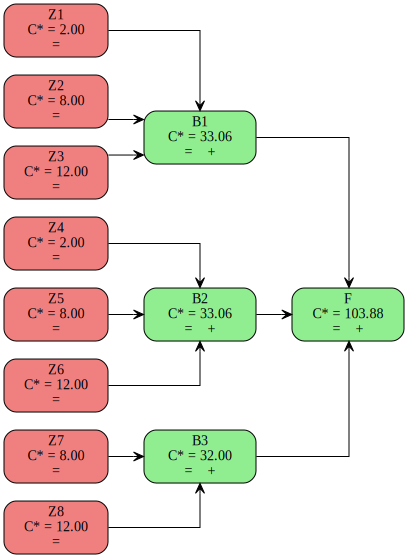

In [14]:
# --- 步骤 5: 可视化决策流程图 ---
dot = graphviz.Digraph('ProductionFlow', comment='问题三 最优决策流程图')
dot.attr(rankdir='LR', size='12,8', splines='ortho')
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')
dot.attr('edge', arrowhead='vee')

# 再次遍历节点以构建图
queue = [root_node]
visited_graph = set()

while queue:
    current_node = queue.pop(0)
    if current_node.name in visited_graph:
        continue
    visited_graph.add(current_node.name)
    
    # 构建节点标签
    cost_str = f"C* = {current_node.min_cost:.2f}"
    decision_str = f"决策 = {current_node.best_decision}"
    label = f"{current_node.name}\n{cost_str}\n{decision_str}"
    
    # 根据决策给节点上色
    color = 'lightgreen'
    if '不检' in current_node.best_decision:
        color = 'lightcoral'
    elif current_node.type == 'part':
        color = 'skyblue'
    
    dot.node(current_node.name, label, fillcolor=color)
    
    for parent in current_node.parents:
        dot.edge(parent.name, current_node.name)
        queue.append(parent)

print("\n--- 生成最优决策流程图 ---")
# 在Jupyter Notebook中，这将直接显示图片
dot